In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical


In [ ]:
data = pd.read_csv('CustomerChurn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:

categorical_columns = data.select_dtypes(include=['object']).columns
#checks dtype
for column in categorical_columns:
  #replaces speci val
    data[column] = data[column].fillna(data[column].mode()[0])


In [ ]:
# categorical to num by labelencoders
label_encoders = {}
#empty dict to store le objects in each col
#loop to convert through le
for column in categorical_columns:
    le = LabelEncoder() #instance
    data[column] = le.fit_transform(data[column]) #tranforms
    label_encoders[column] = le
    #store


In [ ]:
# Define target and extracts
target_column = 'Churn'
y = data[target_column]

# loops and coverts them to lower
if any(col.lower() == 'customerid' for col in data.columns):
    # If found, use the correct case
    customer_id_col = next(col for col in data.columns if col.lower() == 'customerid')
    X = data.drop(columns=[target_column, customer_id_col])
else:
    # If not found, raise  error
    raise KeyError(f"Column 'CustomerID' not found in DataFrame. Available columns: {data.columns}")

# One-hot encode target variable and converts
y_encoded = to_categorical(y)

In [ ]:
# divides training and testing sets ,ensures 20 test and 80 train
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#standardize feature val mean 0 and sd 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN 2d to 3d by 1d
X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]


In [ ]:
# Initialize the CNN model
model = Sequential()

# Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))

# reduce dimensionality, overfitting
model.add(MaxPooling1D(pool_size=2))

# multi to 1d
model.add(Flatten())

# connected
model.add(Dense(64, activation='relu'))

# pre overfitting
model.add(Dropout(0.5))

# fully connected
model.add(Dense(y_train.shape[1], activation='softmax'))

# prepares the model for training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)
#nspecifies num, reduces memory,monitors overfitt

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7265 - loss: 0.5279 - val_accuracy: 0.7879 - val_loss: 0.4384
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7762 - loss: 0.4574 - val_accuracy: 0.7888 - val_loss: 0.4277
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7803 - loss: 0.4588 - val_accuracy: 0.7968 - val_loss: 0.4244
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7868 - loss: 0.4456 - val_accuracy: 0.8012 - val_loss: 0.4197
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8001 - loss: 0.4388 - val_accuracy: 0.8030 - val_loss: 0.4193
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7818 - loss: 0.4447 - val_accuracy: 0.8039 - val_loss: 0.4154
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7869 - loss: 0.4402 - val_accuracy: 0.7995 - val_loss: 0.4177
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7842 - loss: 0.4473 - val_accuracy: 0.

In [ ]:
# model  Evaluate
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy}")

# generates Predicted probabilities
y_pred_proba = model.predict(X_test_reshaped)

# Calculate AUC score,computes charcte
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC Score: {auc_score}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.4108
Test Accuracy: 0.8048261404037476
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC Score: 0.8541190079393833


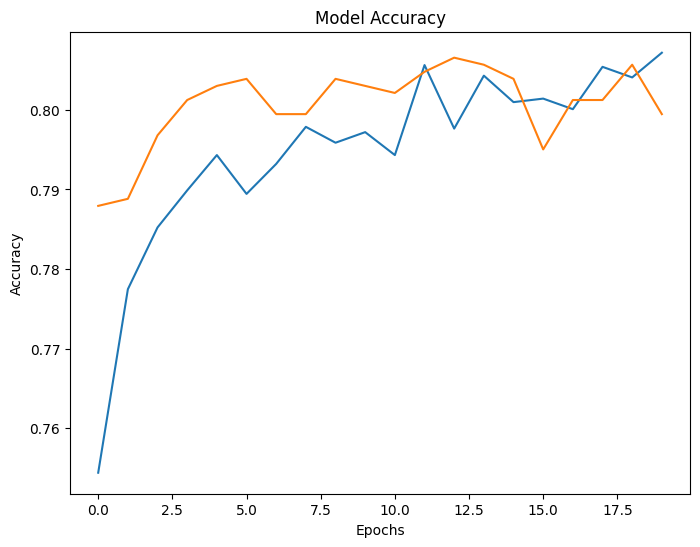

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
#acc from model fit acc values and acc values on the validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()




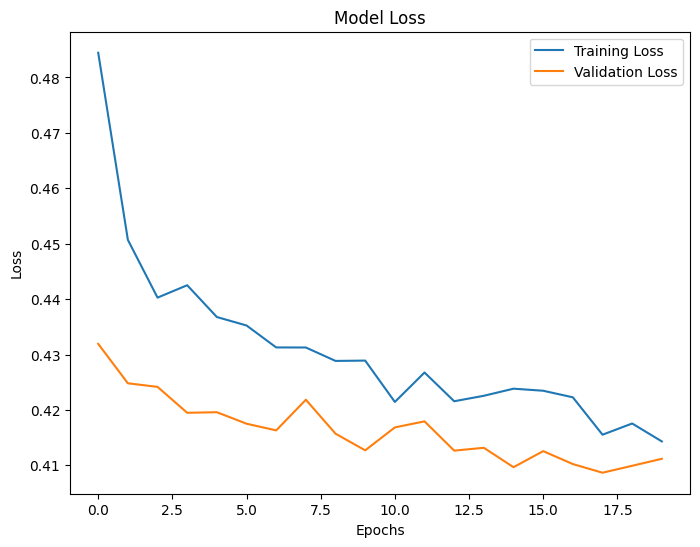

In [ ]:
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()